In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mape, rmse
import holidays
from darts.models import XGBModel
from statsmodels.graphics.tsaplots import plot_pacf
import random
from xgboost import XGBRegressor

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

/Users/floriankuhn/Desktop/MachineLearning/Load-Forecasting/dartenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_load_data():
    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={
        "Actual Total Load [MW] - BZN|SE4": "Actual Load",
        "Time (UTC)": "Time"
    }, inplace=True)
    load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data

data = read_load_data()
  

In [3]:
def import_weather_data(df):
    base_dir = os.getcwd()
    temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
    humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
    solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
    avg_temperature_data = pd.read_csv(temperature_file_path)
    avg_humidity_data = pd.read_csv(humidity_file_path)
    avg_solar_data = pd.read_csv(solar_file_path)
    df['Temperature'] = avg_temperature_data['weighted_avg'].values
    df['Humidity'] = avg_humidity_data['weighted_avg'].values
    df['Solar'] = avg_solar_data['weighted_avg'].values
    return df

data = import_weather_data(data)

In [4]:
def import_swedish_holidays(df):
    years = np.arange(2015, 2025)
    raw_holidays = []
    for date, name in sorted(holidays.Sweden(years=years).items()):
        #if not name == "Söndag":
        #    raw_holidays.append(date)
        raw_holidays.append(date)
    holiday_dates = set(raw_holidays)
    df['is_holiday'] = pd.Series(df.index.date).isin(holiday_dates).astype(int).values
    return df

data = import_swedish_holidays(data)

In [5]:
def create_date_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

data = create_date_features(data)

The partial autocorrelation shows which time lags give new information for our model. Apparently, the first 25 lags and the lags after every n*24 hours (n=1,2,3,...) are important for modeling.

In [134]:
#_ = plot_pacf(data["Actual Load"], lags=168) # checked autocorrelation of load for one week (hourly)

In [6]:
def add_noise_to_covariates(df, noise_level: float = 0.05):
    stochastic_cols = ["Temperature", "Humidity", "Solar"]
    df_noisy = df.copy()

    for col in stochastic_cols:
        if col in df_noisy.columns:
            if col == "Solar":
                # Proportional noise based on value (avoid large noise when value is 0)
                base = df_noisy[col].values
                noise = np.random.normal(0, noise_level * base)
                df_noisy[col] += noise
                df_noisy[col] = df_noisy[col].clip(lower=0)  # Prevent negative solar
            else:
                # Standard deviation-based noise
                std = df_noisy[col].std()
                noise = np.random.normal(0, noise_level * std, size=len(df_noisy))
                df_noisy[col] += noise

    return df_noisy


future_data = add_noise_to_covariates(data)
n_f = 6 #number of considered timesteps for future covariates
n_p = 24
future_data.index = future_data.index + pd.DateOffset(hours=n_f)

In [7]:
def define_time_series(df, future_df, dates=['2024-01-01', '2024-12-01']):

    target_col = "Actual Load"
    feature_cols = [col for col in df.columns if col != target_col]
    
    split_dates = [pd.Timestamp(d) for d in dates]

    train = df[df.index < split_dates[0]]
    valid = df[(df.index >= (split_dates[0]- pd.DateOffset(hours=n_p))) & (df.index < split_dates[1])]
    test = df[df.index >= (split_dates[1]- pd.DateOffset(hours=n_p))] 
    train_future = future_df[future_df.index < (split_dates[0]+ pd.DateOffset(hours=n_f))]  
    valid_future = future_df[(future_df.index >= split_dates[0]) & (future_df.index < (split_dates[1]+ pd.DateOffset(hours=n_f)))]  
    test_future = future_df[future_df.index >= split_dates[1]]  

    train_series = TimeSeries.from_dataframe(train, value_cols=target_col, freq='h')
    valid_series = TimeSeries.from_dataframe(valid, value_cols=target_col, freq='h')
    test_series = TimeSeries.from_dataframe(test, value_cols=target_col, freq='h')
    train_future_series = TimeSeries.from_dataframe(train_future, value_cols=target_col, freq='h')
    valid_future_series = TimeSeries.from_dataframe(valid_future, value_cols=target_col, freq='h')
    test_future_series = TimeSeries.from_dataframe(test_future, value_cols=target_col, freq='h')

    train_covariates = TimeSeries.from_dataframe(train, value_cols=feature_cols, freq='h')
    valid_covariates = TimeSeries.from_dataframe(valid, value_cols=feature_cols, freq='h')
    test_covariates = TimeSeries.from_dataframe(test, value_cols=feature_cols, freq='h')
    train_future_covariates = TimeSeries.from_dataframe(train_future, value_cols=feature_cols, freq='h')
    valid_future_covariates = TimeSeries.from_dataframe(valid_future, value_cols=feature_cols, freq='h')
    test_future_covariates = TimeSeries.from_dataframe(test_future, value_cols=feature_cols, freq='h')
    return (
        train_series, valid_series, test_series,
        train_future_series, valid_future_series, test_future_series,
        train_covariates, valid_covariates, test_covariates,
        train_future_covariates, valid_future_covariates, test_future_covariates
    )
    
(
    train_series, valid_series, test_series,
    train_future_series, valid_future_series, test_future_series,
    train_covariates, valid_covariates, test_covariates,
    train_future_covariates, valid_future_covariates, test_future_covariates
) = define_time_series(data, future_data, dates=['2024-11-02', '2024-12-01'])

In [9]:
model = XGBModel(
    lags=24,                      # past target lags
    lags_past_covariates=n_p,     # past covariates (e.g., weather)
    lags_future_covariates=list(range(n_f)),    # future covariates (e.g., temperature forecasts)
    output_chunk_length=24,      # predict next 24 hours
)

model.fit(
    train_series, 
    past_covariates=train_covariates,
    future_covariates=train_future_covariates
)

#pred = model.predict(24)
pred = model.predict(
    n=24,
    past_covariates=valid_covariates,
    future_covariates=valid_future_covariates
)

17.080583489534806
536.4170584686101


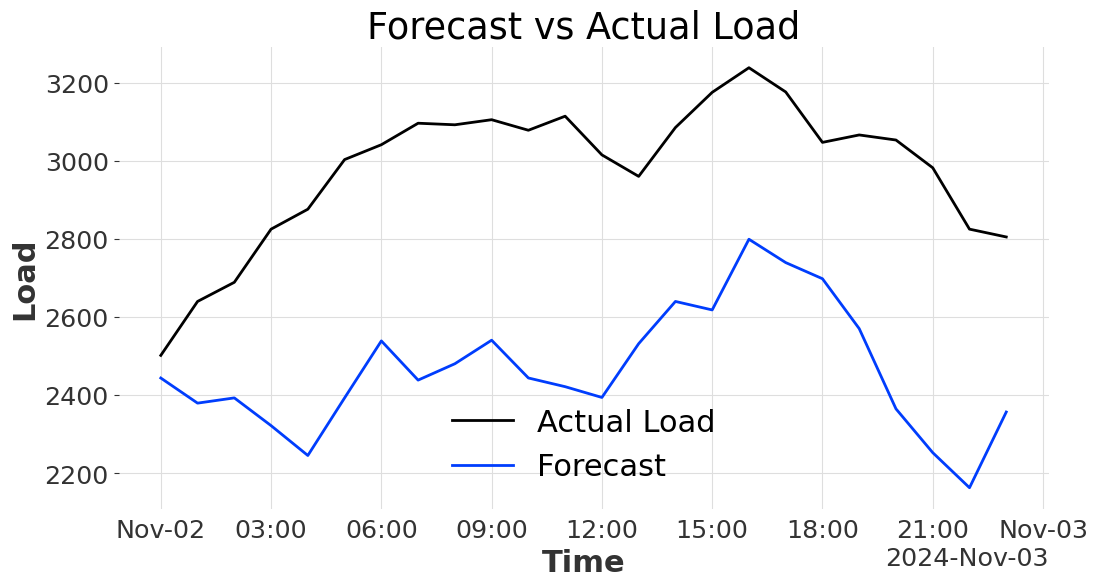

In [12]:
# Plot actual vs predicted
validation = valid_series[n_p:(n_p+len(pred))]
print(mape(validation, pred))
print(rmse(validation,pred))

plt.figure(figsize=(12, 6))
validation.plot(label="Actual Load")  # or use actual_series if that's your ground truth
pred.plot(label="Forecast")
plt.title("Forecast vs Actual Load")
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.show()
